<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/6_Classification_sur_les_images_masqu%C3%A9es_Mod%C3%A8le_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Connexion au Drive, activation du GPU**


**Activation du GPU**



In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


**Connection au drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.applications import VGG16
from keras.layers import Multiply, Flatten, Dense, Input
from keras.models import Model
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model

# **2. Import des images et création du dataframe df**

**Import des images**

In [4]:
### import des images

!unzip -q 'drive/MyDrive/Datascientest/Images_masquees_19082023.zip' > /dev/null 2>&1
# !unzip 'drive/MyDrive/Datascientest/Images_masquees_19082023.zip'

**Création d'un dataframe 'df' répertoriant les accès aux images**

In [5]:
import glob
import pandas as pd

# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste = glob.glob('./fusion/*/*.png')

# Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste = list(map(lambda x : [x, x.split('/')[3].split('_')[0]], liste))

# Créer un DataFrame pandas
df = pd.DataFrame(liste, columns=['Path', 'target'])
df=df.replace(['SNE','BNE'],'NEUTROPHIL')
df=df.replace(['MY','MMY','PMY'],'IG')

# Mapping entre nameLabel et label
mapping = {target: idx for idx, target in enumerate(df.target.unique())}

# Ajouter la colonne 'label' en utilisant le mapping
df['target_numerique'] = df['target'].map(mapping)

df.sort_values('Path')
df

,Path,target,target_numerique
0,./fusion/erythroblast/ERB_674488_fusion.png,ERB,0
1,./fusion/erythroblast/ERB_53114_fusion.png,ERB,0
2,./fusion/erythroblast/ERB_958159_fusion.png,ERB,0
3,./fusion/erythroblast/ERB_692098_fusion.png,ERB,0
4,./fusion/erythroblast/ERB_600852_fusion.png,ERB,0
...,...,...,...
17087,./fusion/platelet/PLATELET_189530_fusion.png,PLATELET,7
17088,./fusion/platelet/PLATELET_127149_fusion.png,PLATELET,7
17089,./fusion/platelet/PLATELET_814291_fusion.png,PLATELET,7
17090,./fusion/platelet/PLATELET_339825_fusion.png,PLATELET,7


In [6]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df.target.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: target, dtype: int64

# **3. Création et entrainement du modèle VGG16 sur les images**

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### **3.1. Séparation du jeu de données**

In [8]:
# Diviser le dataframe en ensembles d'entraînement, de validation et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

### **3.2. Création du générateur de données et chargement des données train, val et test**

In [9]:

datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 224 # taille adaptée à VGG16
width = 224
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='Path',
    y_col='target',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='Path',
    y_col='target',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='Path',
    y_col='target',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **3.3. Vérification du chargement des données**

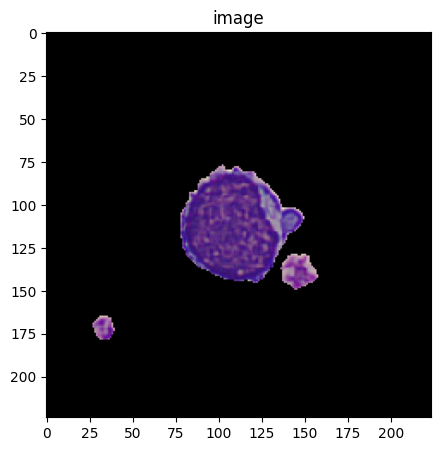

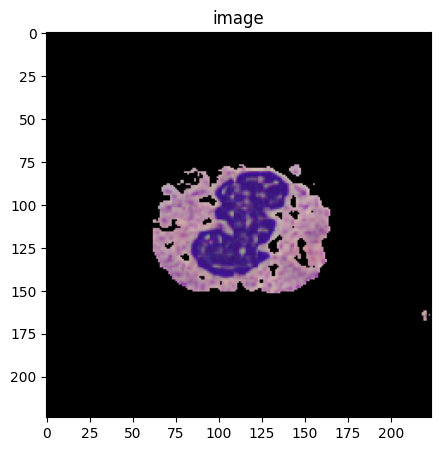

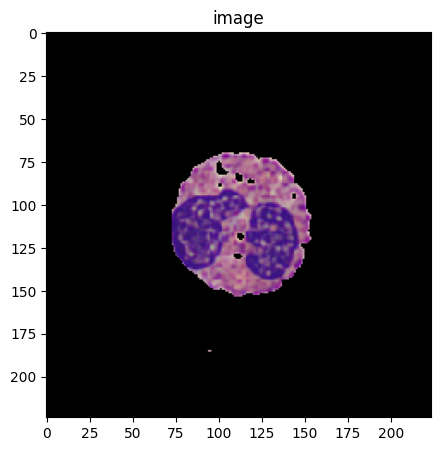

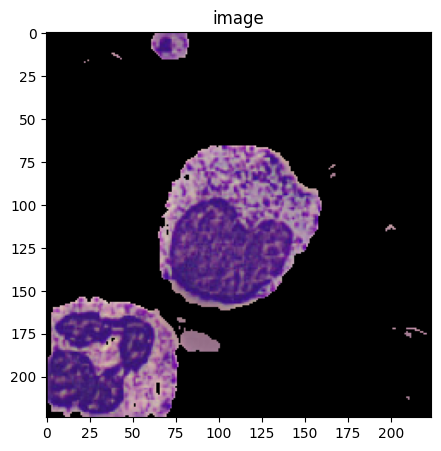

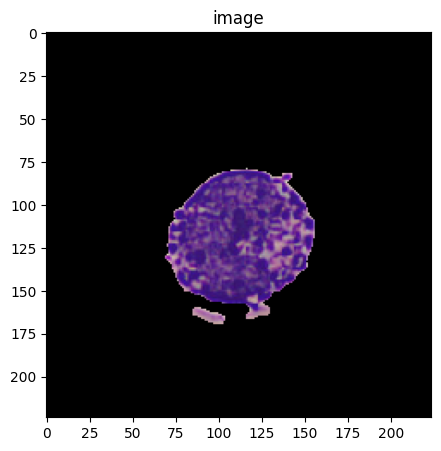

In [12]:
import matplotlib.pyplot as plt


def visualize_sample(image):
    plt.figure(figsize=(10, 5))

    plt.imshow(image[0])
    plt.title("image")

    plt.show()

# Prendre un échantillon du train_dataset
for idx, image in enumerate(train_set):
    if idx >= 5:  # Si vous avez déjà visualisé 5 images, arrêtez la boucle.
        break
    visualize_sample(image[0])

### **3.4. Création du modèle VGG16**

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes pour 8 types de cellules sanguines

model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 [==============================] - 3s 0us/step


### **3.5. Compilation du modèle**

In [14]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

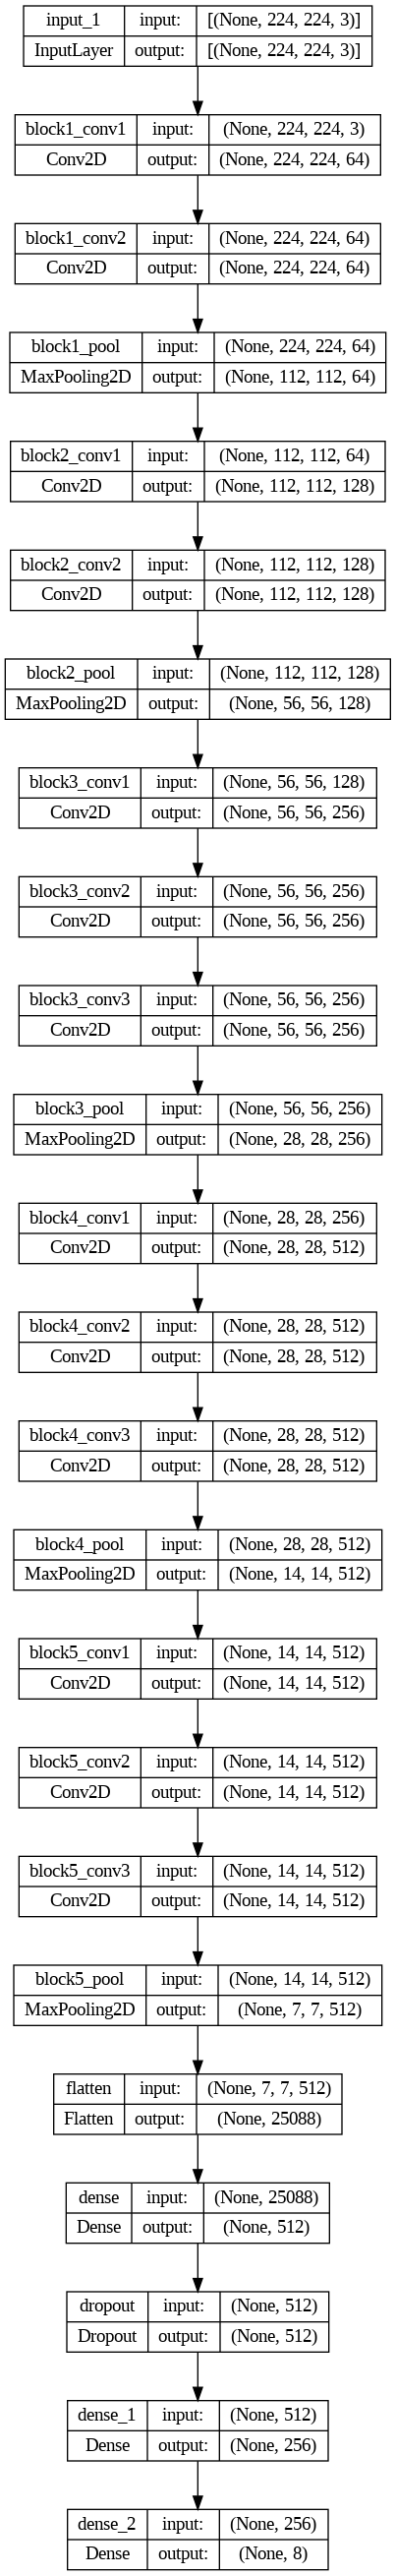

In [16]:
# schéma du modèle Benchmark

plot_model(model, show_shapes=True)

### **3.6. Définition des Callbacks**

In [18]:
### Définition de callbacks

### Sauvegarde automatique des poids

checkpoint_Classification = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/weights_images_masquees_VGG16.h5',
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

### 'Callback' permettant d'ajuster le taux d'apprentissage au cours de l'entrainement
early_stopping = callbacks.EarlyStopping(monitor='val_loss', #métrique à controler
                                         min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, que ce soit à la hausse ou à la baisse, on arrête au bout de 5 épochs
                                         patience=10,
                                         verbose = 0,
                                         mode='min',
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', #métrique à controler
                                         factor=0.1, #factor by which the learning rate will be reduced. new_lr = lr * factor.
                                         patience=5, #number of epochs with no improvement after which learning rate will be reduced.
                                         verbose=0,
                                         mode='min')

### **3.7. Entraînement du modèle benchmark**

In [19]:
### Entrainement model VGG16

steps_per_epochs=nb_img_train//batch_size
validation_steps=nb_img_val//batch_size

Classifier=model.fit(
                    train_set,
                    epochs=100,
                    steps_per_epoch=steps_per_epochs,
                    validation_data=validation_set,
                    validation_steps=validation_steps,
                    callbacks = [lr_plateau, early_stopping]
                    )

Epoch 1/100
273/273 [==============================] - 140s 418ms/step - loss: 0.5463 - categorical_accuracy: 0.8137 - val_loss: 0.2372 - val_categorical_accuracy: 0.9301 - lr: 1.0000e-04
Epoch 2/100
273/273 [==============================] - 111s 407ms/step - loss: 0.1942 - categorical_accuracy: 0.9363 - val_loss: 0.1606 - val_categorical_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 3/100
273/273 [==============================] - 113s 412ms/step - loss: 0.1169 - categorical_accuracy: 0.9636 - val_loss: 0.1946 - val_categorical_accuracy: 0.9449 - lr: 1.0000e-04
Epoch 4/100
273/273 [==============================] - 113s 413ms/step - loss: 0.0916 - categorical_accuracy: 0.9708 - val_loss: 0.1122 - val_categorical_accuracy: 0.9665 - lr: 1.0000e-04
Epoch 5/100
273/273 [==============================] - 113s 413ms/step - loss: 0.0664 - categorical_accuracy: 0.9792 - val_loss: 0.1622 - val_categorical_accuracy: 0.9517 - lr: 1.0000e-04
Epoch 6/100
273/273 [==============================] - 113s 

### **3.8. Sauvegarde du modèle**

In [20]:
#sauvegarde modèle VGG16
model.save('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_VGG16_images_masquees.h5')

In [21]:
#Chargement du modèle VGG16
model_VGG16 = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_VGG16_images_masquees.h5')
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### **3.9. sauvegarde des performances du modèle**

In [22]:
#sauvegarde des performances benchmark
train_acc_benchmark = Classifier.history['categorical_accuracy']
val_acc_benchmark = Classifier.history['val_categorical_accuracy']
train_loss_benchmark = Classifier.history['loss']
val_loss_benchmark = Classifier.history['val_loss']

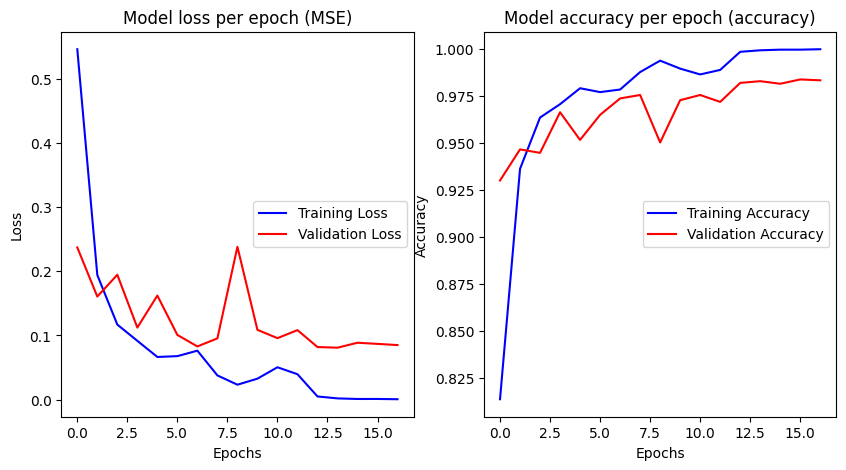

In [23]:
import matplotlib.pyplot as plt

#visualisation des performances
plt.figure(figsize = (10, 5))

plt.subplot(121)
plt.plot(train_loss_benchmark, label = 'Training Loss', color = 'blue')
plt.plot(val_loss_benchmark, label = 'Validation Loss', color = 'red')
plt.title('Model loss per epoch (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='right')

plt.subplot(122)
plt.plot(train_acc_benchmark, label = 'Training Accuracy', color = 'blue')
plt.plot(val_acc_benchmark, label = 'Validation Accuracy', color = 'red')
plt.title('Model accuracy per epoch (accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='right')

plt.show()

### **3.10. Prédictions du modèle sur le jeu test**

In [24]:
#Prediction VGG16
predictions_VGG16 = model.predict(test_set)
y_pred_VGG16 = tf.argmax(predictions_VGG16, axis = 1)

107/107 [==============================] - 15s 141ms/step


### **3.11. Matrice de confusion**

In [25]:
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report

#Création d'une Matrice de confusion
def plot_matrix(y_true, y_pred, label):
  cm = confusion_matrix(y_true.classes, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
  print('Vous retrouverez la matrice de confusion du modèle ci-dessous:')
  plt.figure()
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  print('\nVous retrouverez le rapport de classification du modèle ci-dessous:\n')
  print(classification_report(y_true.classes, y_pred, target_names=label))

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

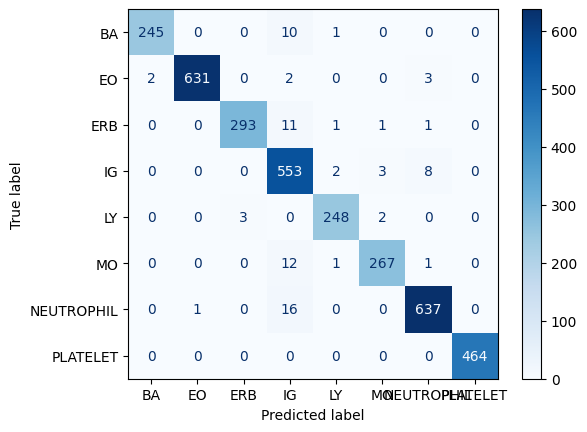


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       0.99      0.96      0.97       256
          EO       1.00      0.99      0.99       638
         ERB       0.99      0.95      0.97       307
          IG       0.92      0.98      0.95       566
          LY       0.98      0.98      0.98       253
          MO       0.98      0.95      0.96       281
  NEUTROPHIL       0.98      0.97      0.98       654
    PLATELET       1.00      1.00      1.00       464

    accuracy                           0.98      3419
   macro avg       0.98      0.97      0.98      3419
weighted avg       0.98      0.98      0.98      3419



In [26]:
plot_matrix(y_true = test_set, y_pred = y_pred_VGG16,label =label_map)

# **4. Interprétablité du modèle VGG16 sur les images masquées**

In [27]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ddcdbc4bed2b091118f67c874d66bab67aa3bc6351be5f0b98f4a8d6aafee9d5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [28]:
#création d'un dataframe pour l'interprétabilité
mapping_dict = {value: key for key, value in label_map.items()}
df_interpretation = test_df.copy()

#Prediction
predictions_VGG16 = model.predict(test_set)
y_pred_VGG16 = tf.argmax(predictions_VGG16, axis = 1)

#conversion
arr = np.array(y_pred_VGG16)
converted_arr = np.vectorize(mapping_dict.get)(arr)
df_interpretation['prediction'] = converted_arr
df_interpretation.head(10)

107/107 [==============================] - 11s 107ms/step


,Path,target,target_numerique,prediction
5293,./fusion/eosinophil/EO_669194_fusion.png,EO,2,EO
10421,./fusion/lymphocyte/LY_266337_fusion.png,LY,4,LY
14126,./fusion/ig/MMY_275256_fusion.png,IG,6,IG
16938,./fusion/platelet/PLATELET_804318_fusion.png,PLATELET,7,PLATELET
7180,./fusion/eosinophil/EO_480614_fusion.png,EO,2,EO
16012,./fusion/platelet/PLATELET_253547_fusion.png,PLATELET,7,PLATELET
8957,./fusion/basophil/BA_152708_fusion.png,BA,3,BA
12397,./fusion/ig/MMY_826421_fusion.png,IG,6,IG
980,./fusion/erythroblast/ERB_927306_fusion.png,ERB,0,ERB
16888,./fusion/platelet/PLATELET_174126_fusion.png,PLATELET,7,PLATELET


In [29]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

def create_dict_explainer(df, model):
  from lime.lime_image import LimeImageExplainer

  category = list(df.target.unique()) #je renseigne les différentes catégories
  n = 2
  height  = 224
  width = 224
  dict_explainer = {}

  for i in category:
    df_new = df.loc[df['target'] == i] #je crée un dataframe reprenant uniquement la catégorie i
    df_new = df_new.loc[df_new['target'] == df_new['prediction']] #je loc sur target = image
    df_new = df_new.sample(n=3) #je choisi 3 images aléatoires

    for j in range(n):
      image_path = df_new.iloc[j].Path
      img = tf.keras.utils.load_img(image_path, target_size=(height, width))
      numpy_image = np.array(img)
      numpy_image = numpy_image / 255

      explainer = LimeImageExplainer(verbose = False)
      explanation = explainer.explain_instance(image = numpy_image,
                                         classifier_fn = model.predict,
                                         top_labels = 1,
                                         num_samples = 1000)
      # Store the object in the dictionary with a dynamic key
      key = f"explanation_{i}_{j}"
      dict_explainer[key] = explanation

  return dict_explainer

In [30]:
%%capture
dict_explainer_benchmark = create_dict_explainer(df_interpretation, model)

In [31]:
def plot_explainer(dict_explainer):
  from skimage.segmentation import mark_boundaries
  for cle, objet in dict_explainer.items():
    print("Analyse LIME pour l'image {}".format(cle))
    temp_1, mask_1 = objet.get_image_and_mask(objet.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = objet.get_image_and_mask(objet.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(mark_boundaries(temp_1, mask_1))
    plt.title('SuperPixel pour cette catégorie')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(mark_boundaries(temp_2, mask_2))
    plt.title('Répartition des pixels positifs (vert) et négatifs (rouge)')
    plt.axis('off')
    plt.show()

Analyse LIME pour l'image explanation_EO_0


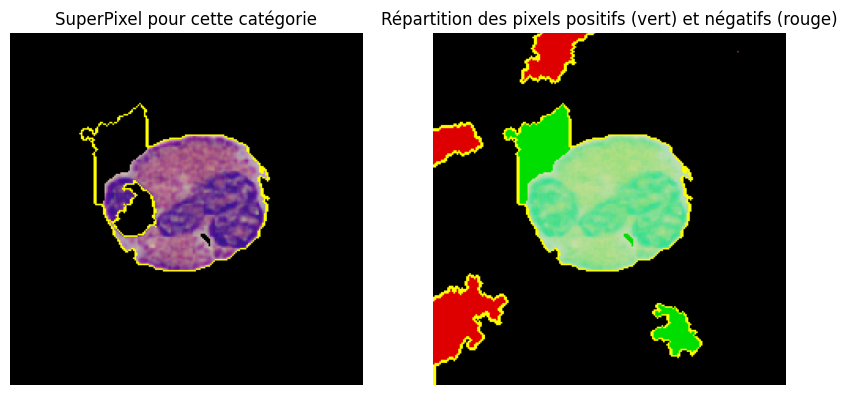

Analyse LIME pour l'image explanation_EO_1


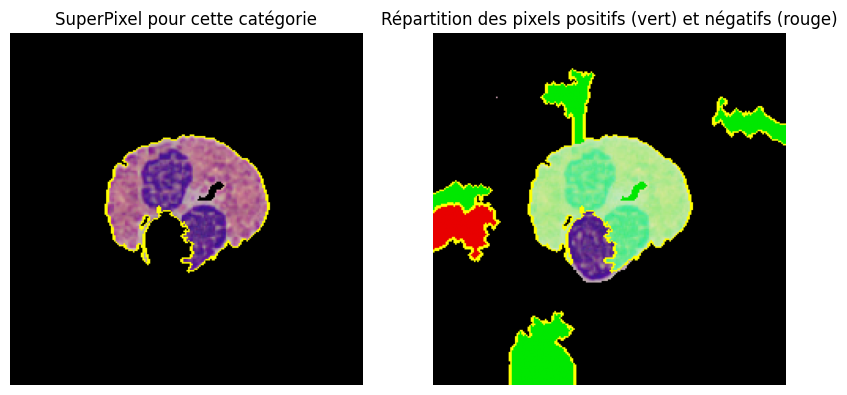

Analyse LIME pour l'image explanation_LY_0


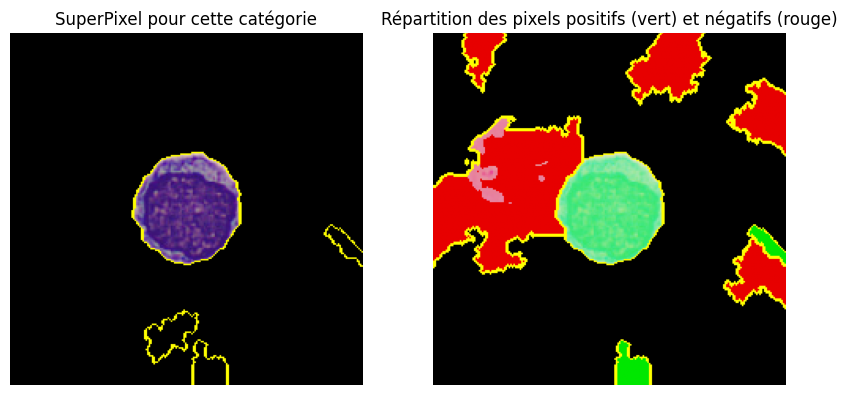

Analyse LIME pour l'image explanation_LY_1


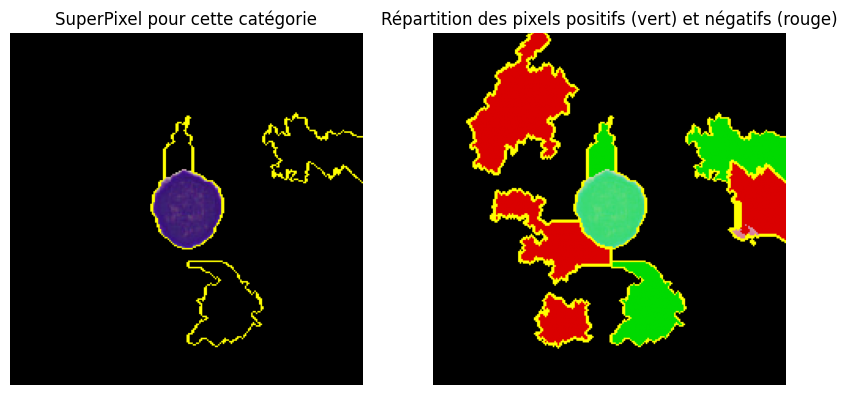

Analyse LIME pour l'image explanation_IG_0


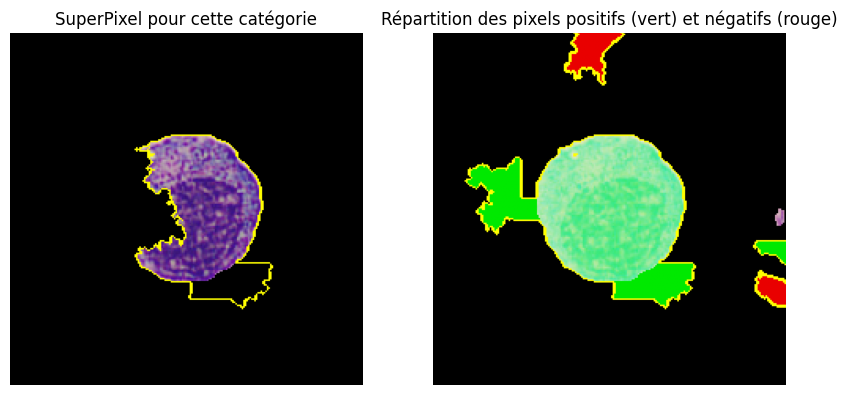

Analyse LIME pour l'image explanation_IG_1


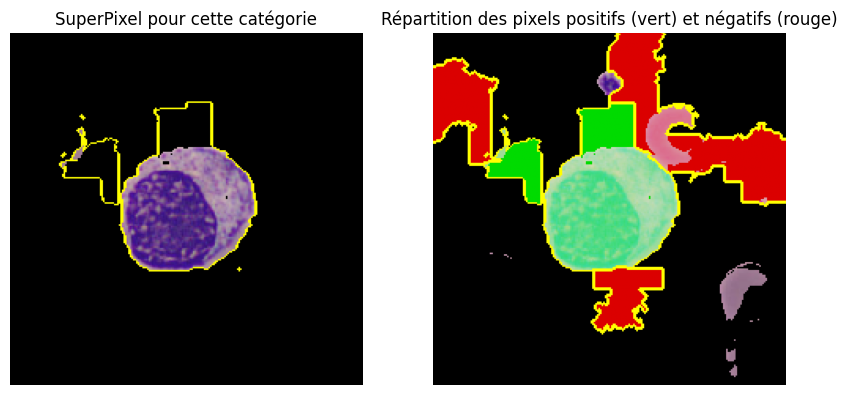

Analyse LIME pour l'image explanation_PLATELET_0


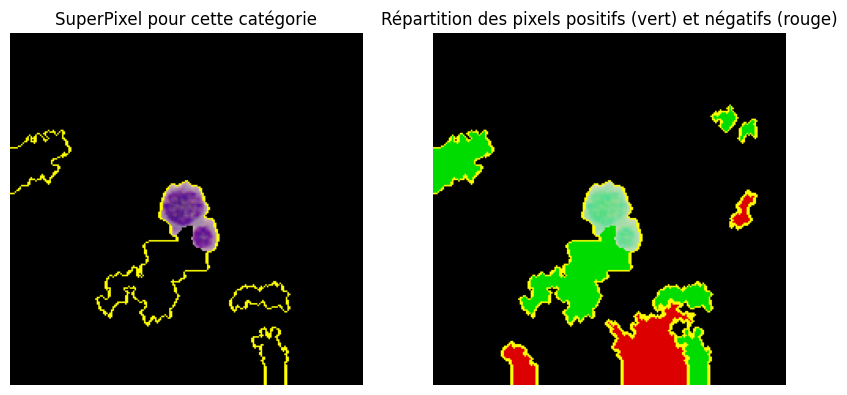

Analyse LIME pour l'image explanation_PLATELET_1


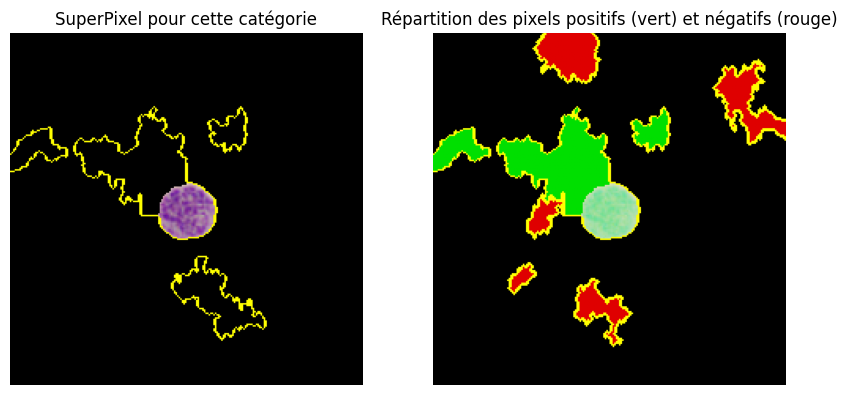

Analyse LIME pour l'image explanation_BA_0


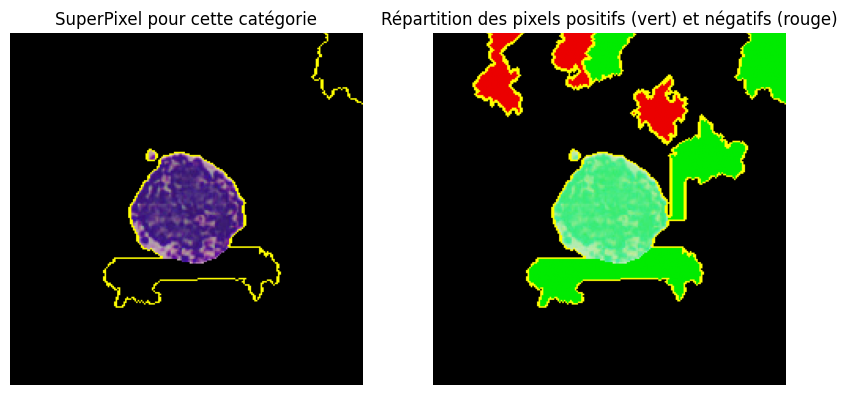

Analyse LIME pour l'image explanation_BA_1


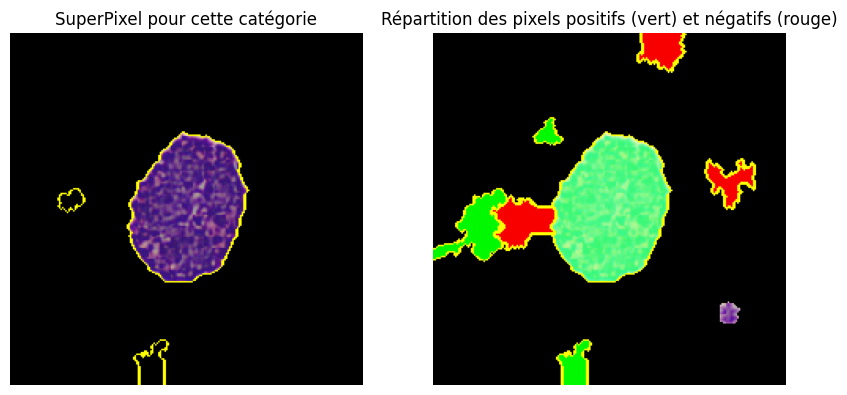

Analyse LIME pour l'image explanation_ERB_0


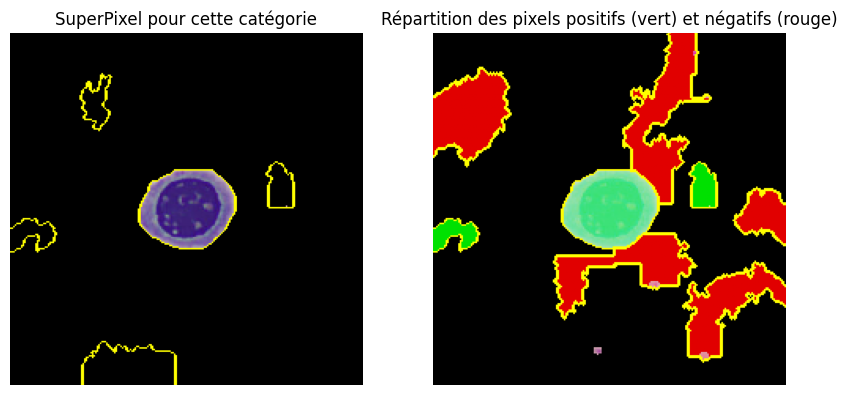

Analyse LIME pour l'image explanation_ERB_1


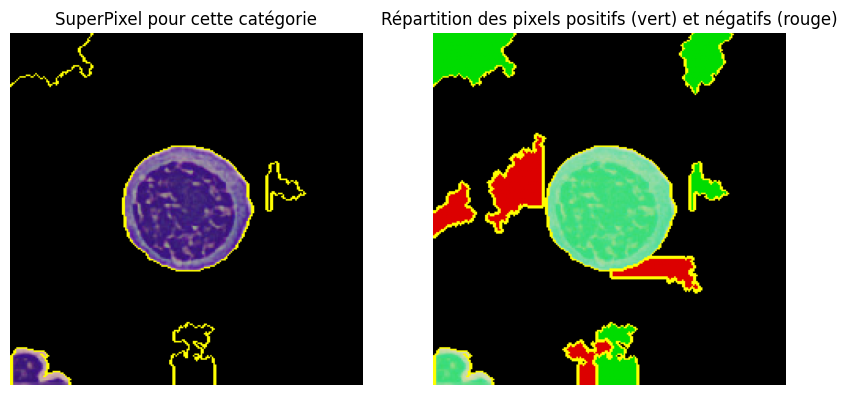

Analyse LIME pour l'image explanation_NEUTROPHIL_0


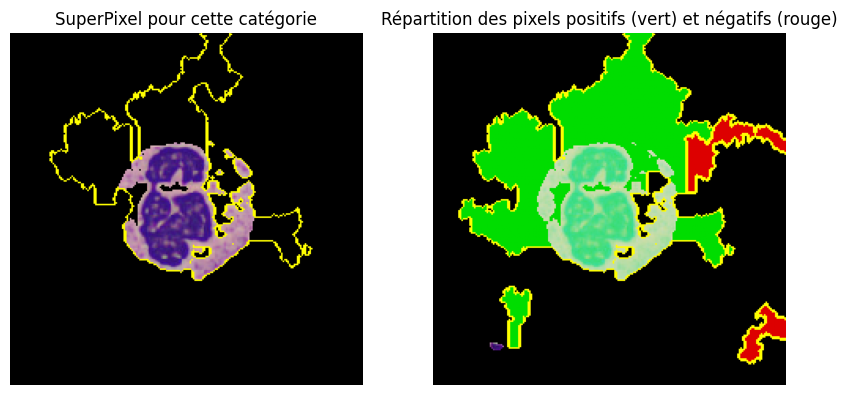

Analyse LIME pour l'image explanation_NEUTROPHIL_1


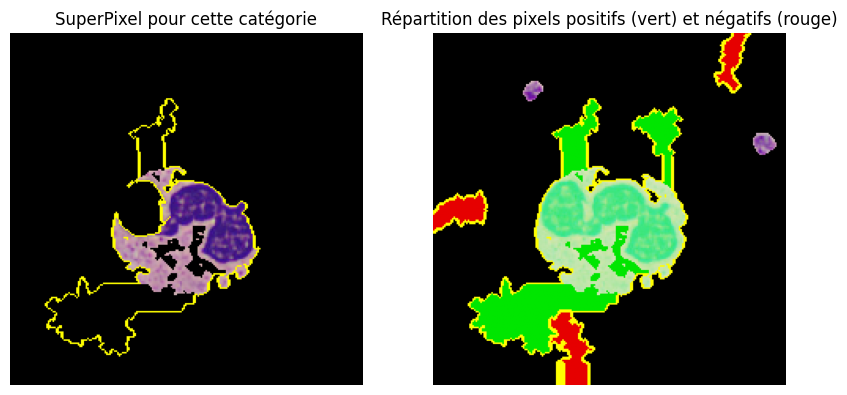

Analyse LIME pour l'image explanation_MO_0


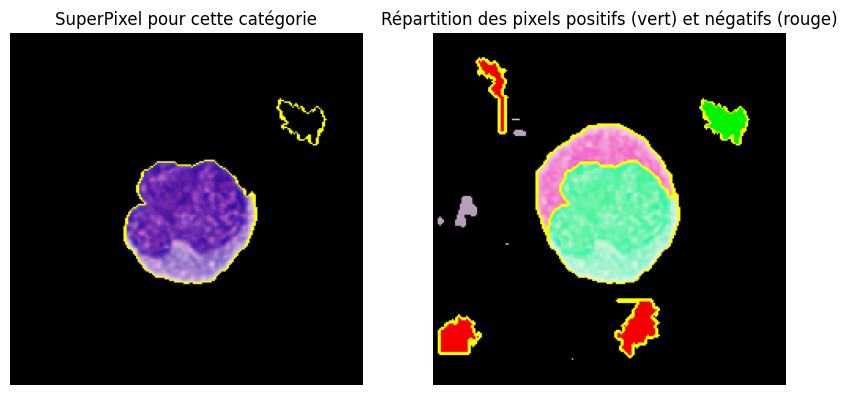

Analyse LIME pour l'image explanation_MO_1


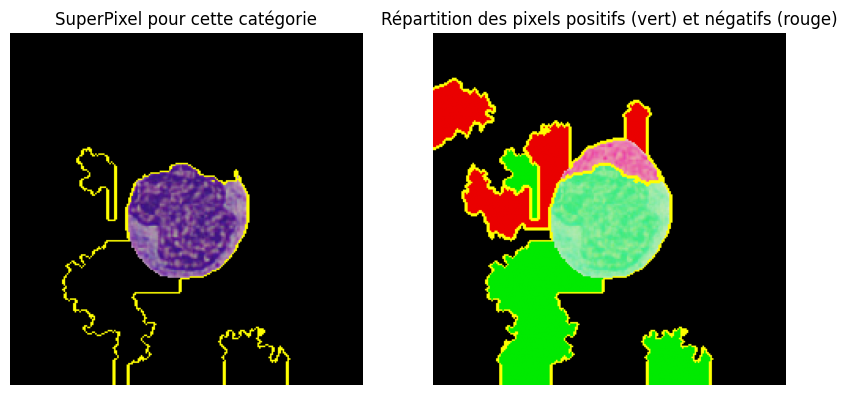

In [32]:

plot_explainer(dict_explainer_benchmark)